In [ ]:
!pip -q install lightgbm optuna joblib

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import optuna, joblib, os, gc, warnings
warnings.filterwarnings("ignore")

SEED = 777
np.random.seed(SEED)

In [ ]:
ROOT = "/content"
train_path = os.path.join(ROOT, "geosciai2025_sw_train.csv")
test_path  = os.path.join(ROOT, "geosciai2025_sw_all_test_timeshift.csv")

def read_csv(fp):
    df = pd.read_csv(fp)
    df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"], utc=True)
    return df.sort_values("datetime").reset_index(drop=True)

train_raw = read_csv(train_path)
test      = read_csv(test_path)

## 訓練データのカットオフ(2019-12-31 0:00まで)
cutoff = pd.Timestamp("2019-12-31 00:00", tz="UTC")
train = train_raw.loc[train_raw["datetime"] <= cutoff].copy()

# 24 h 先をターゲットに
train["dst_t+24"] = train["dst (nT)"].shift(-24)
train = train.iloc[:-24]

In [ ]:
train.head(3)

,datetime,dst (nT),bt (nT),bv (nT),bthe (deg),bphi (deg),bx (nT),by (nT),bz (nT),temp (K),...,beta,amach,mmach,qi,kp10,sunspot,ap (nT),f10.7,lymana (W/m^2),dst_t+24
0,2009-01-01 00:00:00+00:00,-7.0,4.4,4.2,158.7,10.7,-3.8,1.2,1.2,109738.0,...,0.92,7.6,5.7,0.0206,17.0,0.0,6.0,66.6,0.005982,-3.0
1,2009-01-01 01:00:00+00:00,-5.0,4.2,4.0,167.4,-1.4,-3.9,0.9,0.1,119938.0,...,1.11,8.2,5.8,0.0177,17.0,0.0,6.0,66.6,0.005982,-5.0
2,2009-01-01 02:00:00+00:00,-4.0,4.2,3.9,157.0,-17.3,-3.4,1.6,-0.8,171848.0,...,1.98,10.4,6.3,0.0111,17.0,0.0,6.0,66.6,0.005982,-6.0


In [ ]:
train.tail(3)

,datetime,dst (nT),bt (nT),bv (nT),bthe (deg),bphi (deg),bx (nT),by (nT),bz (nT),temp (K),...,beta,amach,mmach,qi,kp10,sunspot,ap (nT),f10.7,lymana (W/m^2),dst_t+24
96358,2019-12-29 22:00:00+00:00,-1.0,5.0,4.9,282.0,2.9,1.0,-4.6,-0.9,14464.0,...,2.12,9.3,5.5,0.0138,7.0,0.0,3.0,69.6,0.006111,10.0
96359,2019-12-29 23:00:00+00:00,-1.0,4.9,4.9,280.1,2.6,0.9,-4.7,-0.9,15552.0,...,2.04,8.9,5.4,0.0150,7.0,0.0,3.0,69.6,0.006111,11.0
96360,2019-12-30 00:00:00+00:00,0.0,4.0,3.9,276.2,3.2,0.4,-3.7,-0.7,16971.0,...,3.63,11.5,5.7,0.0089,0.0,0.0,0.0,68.6,0.006109,8.0


In [ ]:
def add_domain_features(df):
    df["Bs"] = df["bz (nT)"].clip(upper=0).abs()
    df["BT"] = np.sqrt(df["by (nT)"]**2 + df["bz (nT)"]**2)
    df["theta_c"] = np.degrees(np.arctan2(df["BT"], df["bx (nT)"]))
    μ0 = 4*np.pi*1e-7
    df["epsilon"] = 1e3 * (df["vsw (km/s)"] * (df["BT"]**2) * (np.sin(np.radians(df["theta_c"])/2)**4)) / μ0
    df["phi_newell"] = (df["vsw (km/s)"]**(4/3)) * (df["BT"]**(2/3)) * (np.sin(np.radians(df["theta_c"])/2)**(8/3))
    df["Ey_calc"] = -1e-3 * df["vsw (km/s)"] * df["bz (nT)"]
    df["Q_burton"] = 0.20 * df["Ey_calc"] - 1.5
    df["Dst_star"] = df["dst (nT)"] - 7.26 * np.sqrt(df["pdyn (nPa)"]) + 11
    return df

In [ ]:
def add_fourier_features(df: pd.DataFrame,
                         periods_hours=(24, 12, 6, 648, 8766),
                         order=1,
                         time_col="datetime") -> list:
    # 連続時間軸 (単位 = hour) を取得
    t = (df[time_col] - df[time_col].min()).dt.total_seconds() / 3600.0
    new_cols = []
    for P in periods_hours:
        for k in range(1, order + 1):
            w = 2 * np.pi * k / P
            sin_col = f"sin_{P}h_k{k}"
            cos_col = f"cos_{P}h_k{k}"
            df[sin_col] = np.sin(w * t)
            df[cos_col] = np.cos(w * t)
            new_cols.extend([sin_col, cos_col])
    return new_cols

In [ ]:
train = add_domain_features(train)
test  = add_domain_features(test)

In [ ]:
fourier_cols = add_fourier_features(train, order=1)
_            = add_fourier_features(test,  order=1)

In [ ]:
def make_temporal_features(df, lags=24, windows=(3,6,12)):
    feature_cols = []
    for lag in range(1, lags+1):
        for col in ["dst (nT)", "bz (nT)", "Bs", "Ey_calc", "phi_newell", "Q_burton",
                    "vsw (km/s)", "pdyn (nPa)", "nsw (n/cc)"]:
            new_col = f"{col}_lag{lag}"
            df[new_col] = df[col].shift(lag)
            feature_cols.append(new_col)
    for w in windows:
        for col in ["Bs", "Ey_calc", "phi_newell"]:
            for stat, func in zip(["mean","std","min","max"],
                                  [np.mean,np.std,np.min,np.max]):
                new_col = f"{col}_{stat}{w}"
                df[new_col] = df[col].rolling(window=w, min_periods=1).apply(func)
                feature_cols.append(new_col)
    return df, feature_cols

train, F_cols  = make_temporal_features(train)
test,  _        = make_temporal_features(test)

In [ ]:
# 欠損補完（先頭分は線形補間→残り 0）
train[F_cols] = train[F_cols].interpolate(limit_direction="both").fillna(0)
test[F_cols]  = test[F_cols].interpolate(limit_direction="both").fillna(0)

In [ ]:
TARGET = "dst_t+24"
FEATS  = F_cols + ["Bs","BT","theta_c","epsilon","phi_newell",
                   "Ey_calc","Q_burton","Dst_star","beta","amach","mmach",
                   "sunspot","f10.7","lymana (W/m^2)","kp10","ap (nT)"] + fourier_cols

# TimeSeriesSplit → 5 fold Walk-Forward (2018 以降を val に近くなるように)
tscv = TimeSeriesSplit(n_splits=5, test_size=24*365)  # 1 年 ≒ 8760 h
X, y = train[FEATS], train[TARGET]

In [ ]:
## 特徴量の総数を出力
print(f"Total feature count: {len(FEATS)}")

Total feature count: 278


In [ ]:
def objective(trial):
    params = {
        "objective":"regression",
        "metric":"rmse",
        "verbosity":-1,
        "boosting_type":"gbdt",
        "seed":SEED,
        "feature_fraction": trial.suggest_float("ff",0.6,1.0),
        "num_leaves":       trial.suggest_int("leaves",128,1024),
        "max_depth":        trial.suggest_int("depth",6,16),
        "learning_rate":    trial.suggest_float("lr",0.01,0.1,log=True),
        "lambda_l1":        trial.suggest_float("l1",0,5),
        "lambda_l2":        trial.suggest_float("l2",0,5),
        "min_data_in_leaf": trial.suggest_int("min_data",50,300),
    }
    rmses=[]
    for tr_idx,va_idx in tscv.split(X):
        m=lgb.train(params,lgb.Dataset(X.iloc[tr_idx],label=y.iloc[tr_idx]),
                    num_boost_round=3000,
                    valid_sets=[lgb.Dataset(X.iloc[va_idx],label=y.iloc[va_idx])])
        rmses.append(root_mean_squared_error(y.iloc[va_idx],m.predict(X.iloc[va_idx])))
    return np.mean(rmses)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, timeout=60*30)
best_params = study.best_params
best_params.update({"objective":"regression",
                    "metric":"rmse",
                    "verbosity":-1,
                    "seed":SEED})

print("Best CV RMSE:",study.best_value)
print("Best params :", best_params)

[I 2025-05-12 12:33:42,982] A new study created in memory with name: no-name-cc8dbeaa-13b0-45f2-8aca-a0d963000bd1
[I 2025-05-12 13:44:50,171] Trial 0 finished with value: 13.193469892904243 and parameters: {'ff': 0.980763251666978, 'leaves': 779, 'depth': 15, 'lr': 0.011254298441689799, 'l1': 4.729100024947148, 'l2': 1.2507863559074446, 'min_data': 100}. Best is trial 0 with value: 13.193469892904243.


Best CV RMSE: 13.193469892904243
Best params : {'ff': 0.980763251666978, 'leaves': 779, 'depth': 15, 'lr': 0.011254298441689799, 'l1': 4.729100024947148, 'l2': 1.2507863559074446, 'min_data': 100, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 777}


In [ ]:
dall = lgb.Dataset(X, label=y)
best_iter = int(study.best_trial.user_attrs.get("best_iteration", 4000))
model = lgb.train(best_params, dall, num_boost_round=best_iter)

In [ ]:
imp = pd.Series(model.feature_importance(), index=FEATS).sort_values(ascending=False).head(20)
print("\nTop-20 Importance\n", imp)


Top-20 Importance
 sin_8766h_k1        3465
cos_8766h_k1        3443
sin_648h_k1         3201
cos_648h_k1         2914
lymana (W/m^2)      2832
f10.7               2597
sunspot             2205
phi_newell_min12    1590
Ey_calc_min12       1573
phi_newell_max12    1352
Ey_calc_max12       1230
phi_newell_std12    1166
Dst_star            1128
Ey_calc_std12       1061
sin_24h_k1          1041
cos_24h_k1          1011
beta                 934
phi_newell_min6      916
Ey_calc_min6         885
pdyn (nPa)_lag1      845
dtype: int32


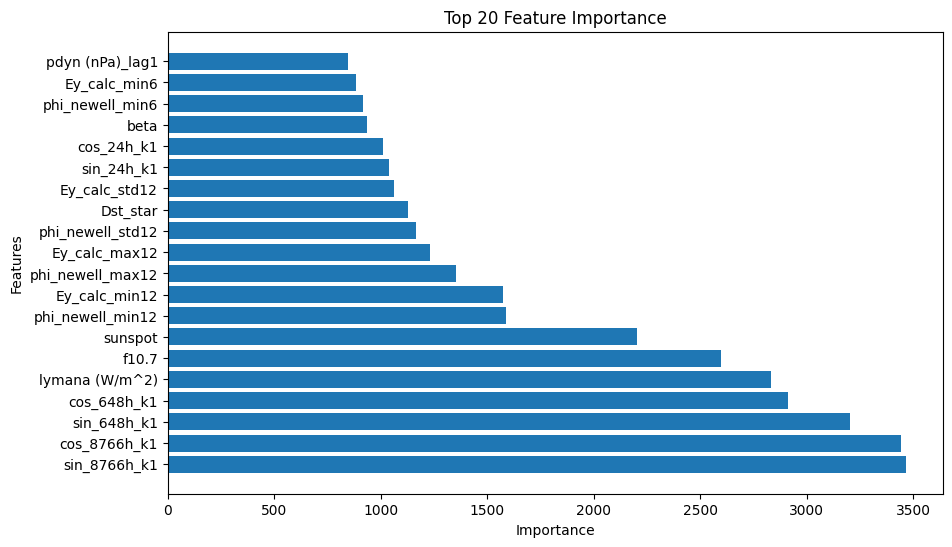

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(imp.index, imp.values)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importance")
plt.show()

In [ ]:
test_pred_all = model.predict(test[FEATS])

In [ ]:
mask = (test["datetime"] >= "2024-05-02") & (test["datetime"] <= "2024-05-31 23:00")
y_true = test.loc[mask, "dst (nT)"].values
y_pred = test_pred_all[mask]

In [ ]:
rmse_test = root_mean_squared_error(y_true, y_pred)
print(f"Test RMSE 2024-05-02–31: {rmse_test:.3f} nT")

Test RMSE 2024-05-02–31: 49.169 nT


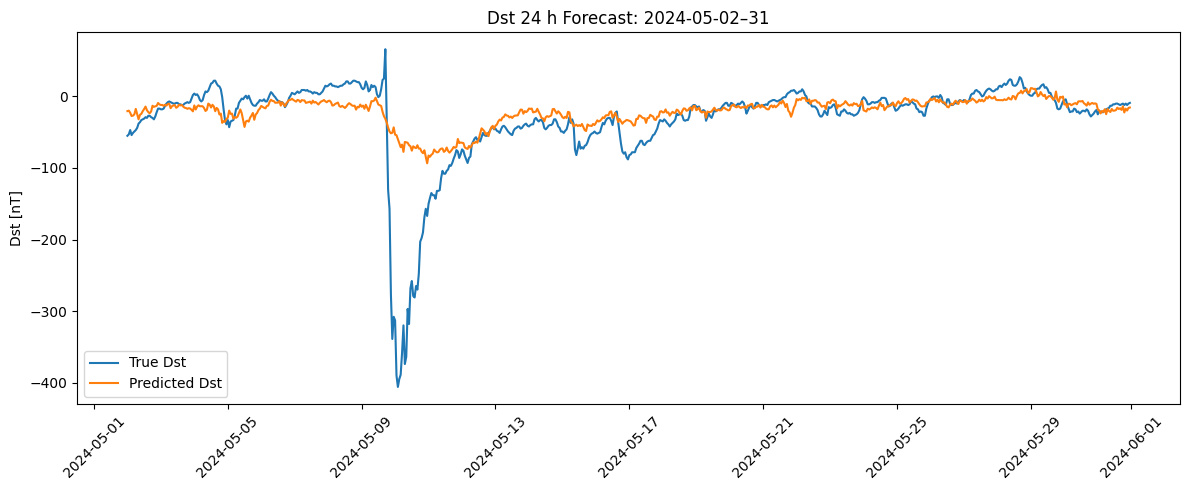

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test.loc[mask,"datetime"], y_true, label="True Dst", lw=1.5)
plt.plot(test.loc[mask,"datetime"], y_pred, label="Predicted Dst", lw=1.5)
plt.title("Dst 24 h Forecast: 2024-05-02–31")
plt.ylabel("Dst [nT]")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sub = pd.DataFrame({"datetime": test["datetime"], "dst_pred": test_pred_all})
sub.to_csv("submission_dst2_1.csv", index=False)

In [ ]:
sub_2 = pd.DataFrame(
    {
        "datetime": test["datetime"],
        "dst_pred": test_pred_all,
        "dst_true": test["dst (nT)"]
        })

sub_2.to_csv("submission_dst_Part2_2.csv", index=False)